# Labo 03

## Speaker recognition experiments

You will be provided with a database of vowels spoken by men, women and children (of 3, 5 and
7 years old). The task will be to train artificial neural networks to recognize the speaker having
produced the given sounds and evaluate its performance (e.g., by cross-validation). The file
vowels.zip contains the sounds in WAV format. They have been collected by the team of Prof.
Peter Assmann of the School of Behavioral and Brain Sciences of Texas University in Dallas. You
will also find a set of synthetic sounds corresponding to each vowel and each speaker. Please
read the file 0_README.txt for more information.

This experiment is the continuation of the practical work on data exploration but this time instead
of visualizing data and trying to classify vowels recordings with your own rules or with KNN, you
will use a Multilayer Perceptron and you will choose the best model based on a performance
assessment of different models’ architectures and hyperparameters.
We suggest you use the model_selection notebook to have a skeleton of code for the model
selection you have to perform for the problem of speaker recognition. You may also reuse some
code of other notebooks.

## TODO

For each of the following experiments, provide a brief description of the number of observations
of each class, the features being used to train the model, the procedure (explain) for selecting
the final model (e.g., use the model_selection.ipynb notebook), the description of the final model
and its performance evaluation (i.e., provide the cross-validation results, the confusion matrix
and the F-score). Comment your results.

1. Man vs Woman. Use only the natural voices of men and women to train a neural network
that recognizes the gender of the speaker.
2. Man vs. Woman vs. children (3 classes)
3. Design a final experiment of your choice (e.g., using your own voice or the synthetic
voices).

### Loading packages

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import sys
import os
import scipy.io.wavfile as wav
from ipywidgets import interact, widgets
import glob
from python_speech_features import mfcc

%matplotlib inline

### Loading data

In [2]:
PATH = './vowels/vowels'

nat_paths = glob.glob(os.path.join(PATH, 'n*.wav'))
synt_paths = glob.glob(os.path.join(PATH, 's*.wav'))

# Here we read the wave files and store their content in lists
nat_audios = [wav.read(path) for path in nat_paths]
synt_audios = [wav.read(path) for path in synt_paths]

# Take the median of each audio files across the different windows
nat_mfcc_median = np.array([np.median(mfcc(record,samplerate=sample_rate, nfft=1024), axis=0) for sample_rate, record in nat_audios])
synt_mfcc_median = np.array([np.median(mfcc(record,samplerate=sample_rate, nfft=1024), axis=0) for sample_rate, record in synt_audios])

In [3]:
# Normalisation fonction
def normalize(array):
    xMin = array.min(axis=0)
    xMax = array.max(axis=0)
    
    array = (array - xMin)/(xMax-xMin)
    return array

In [4]:
# Creating dataset
def create_dataset(nat: np.ndarray, synt: np.ndarray):
    mix = normalize(np.concatenate((nat, synt)))
    (nat, synt) = np.split(mix, 2)
    return np.concatenate((np.insert(nat, 13, -1, axis=1), (np.insert(synt, 13, 1, axis=1))))

In [5]:
dataset = create_dataset(nat_mfcc_median, synt_mfcc_median)

## The MLP
Import the code of the backpropagation with momentum algorithm

In [6]:
import mlp_backprop_momentum as mlp

## Cross-validation
Import the code of the cross-valdidation test

In [7]:
import k_fold_cross_validation as cv

## Exploring the number of epochs
Let's first try to estimate how many iterations of the backpropagation algorithm are enough to find a low training error. We fixed the learning rate to 0.001 and the momentum term to 0.5. These values are just initial guesses which work well in most of the cases. Feel free to change these values if:

- the error curve oscillates -> reduce the learning rate
- the error curve is very smooth and does not change -> increase the learning rate
- the model does not converge -> try different values of momentum

This initial test is performed by only tracking the training error. Hence, it is impossible to know if the model overfits or not. We will only know if the model's complexity is enough for learning the task.

The following snippet also changes the number of hidden neurons from the simplest model possible (2 neurons) to a model having a complexity you think is excesive. Model selection in artificial neural networks is based on the experience. Moreover, notice that the MLPs are initialized several times to avoid a too bad result due to an unlucky initialization.

In [8]:
N_INITS = 10
EPOCHS = 550
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.8

In [9]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:14]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


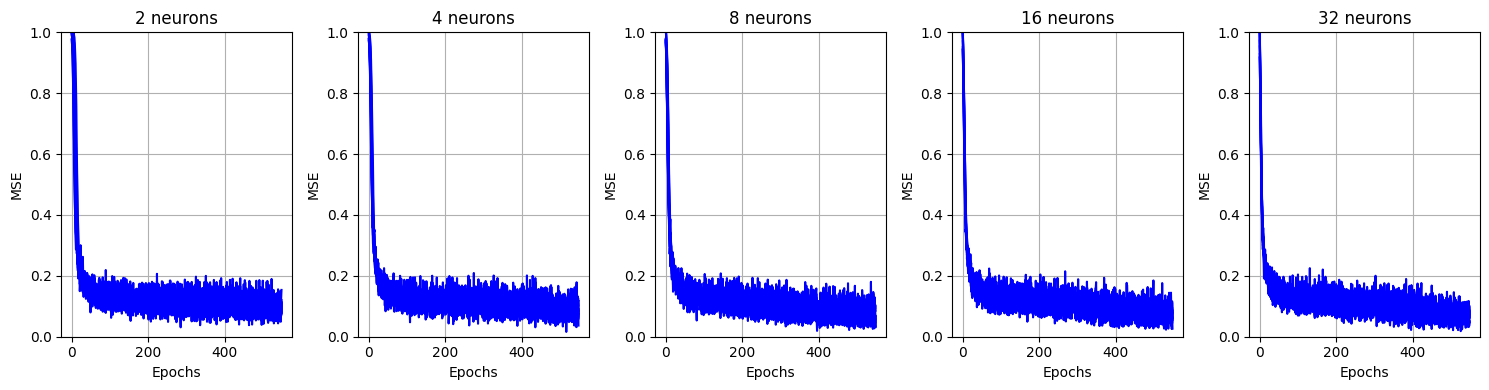

In [10]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

In every case, from 2 to 32 neurons in the hidden layer, the training error does not improve anymore after 50 iterations. The result of this test indicates that the minimum number of iterations needed are around 20 iterations (Taking into account only the training error!).

## Exploring the number of hidden neurons
Knowing that there are no significant improvements after 50 iterations, we can now further explore how the complexity of the model (number of hidden neurons) is linked to the generalization performance (test error). The following snippet allows you to explore both the number of epochs and the number of hidden neurons without restarting the training.

In [11]:
EPOCHS = 200
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]

In [12]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 25 neurons...
Testing 30 neurons...


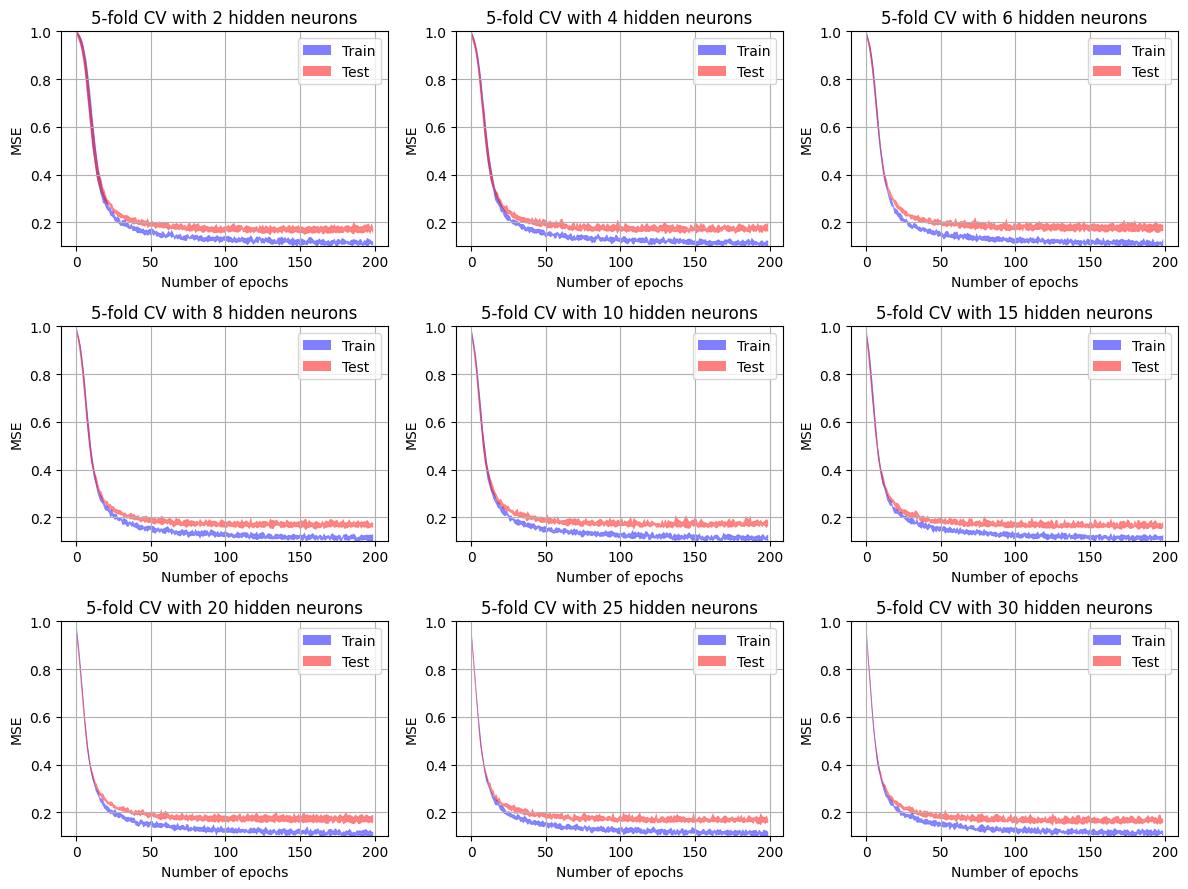

In [13]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(v_min,v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

Notice that the test error does not improve much between 40 and 60 iterations, neither adding more hidden neurons after 4 units. 

The following snippet shows a different visualization.

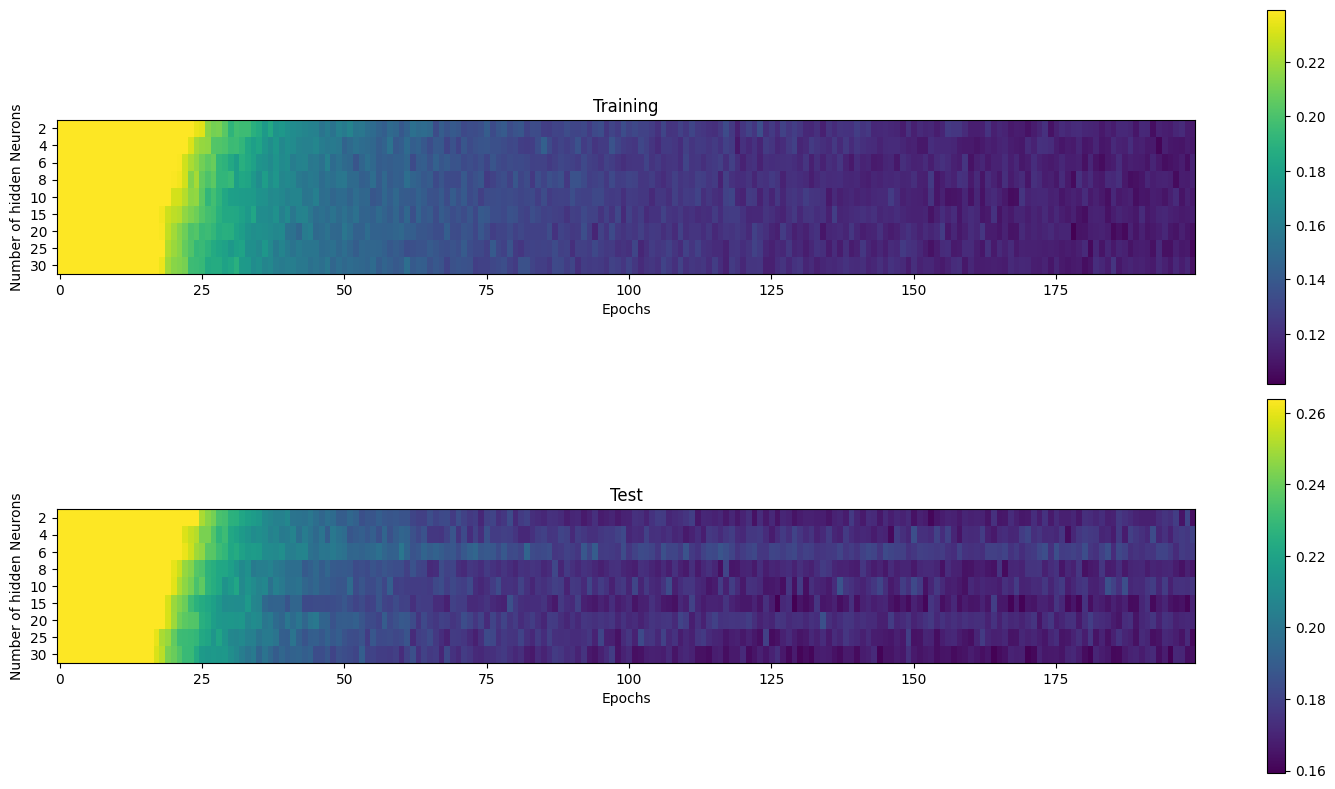

In [14]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

For this particular problem, having more hidden neurons or running the backpropagation algorithm longer does not affect negatively the performance of the model. However, more iterations implies more processing time and more neurons implies more ressources and this should be avoided.

## The final model
An artificial neural network with 2 neurons and 40 iterations of the backpropagation algorithm is enough to solve the problem.

In [15]:
nn = mlp.MLP([13,4,1], 'tanh')

K = 5
EPOCHS=100
LEARNING_RATE=0.001
MOMENTUM=0.8

In [16]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=EPOCHS,
                                                          threshold=0.0)

In [17]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.12112499115750788
MSE test:  0.14990106414469379
Confusion matrix:
[[174.   6.]
 [ 13. 167.]]


In [18]:
def plot_confusion_matrix(conf_matrix, classes_names):
    fig, ax = pl.subplots()
    im = ax.imshow(conf_matrix, cmap="viridis")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(classes_names)), labels=classes_names)
    ax.set_yticks(np.arange(len(classes_names)), labels=classes_names)

    # Rotate the tick labels and set their alignment.
    pl.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(classes_names)):
        for j in range(len(classes_names)):
            text = ax.text(j, i, conf_matrix[i, j], fontweight="bold", fontsize="large", ha="center", va="center", c="r")

    fig.tight_layout()
    pl.show()


In [19]:
def accuracy(matrix):
    return (matrix[0,0] + matrix[1,1])/ matrix.sum()

def f1_score(matrix):
    precision = matrix[1,1] / (matrix[1,0] + matrix[1,1])
    recall = matrix[1,1] / (matrix[0,1] + matrix[1,1])
    return 2 * precision * recall / (precision + recall)

In [20]:
print(f"Accuracy = {accuracy(conf_mat)}")
print(f"F1_score = {f1_score(conf_mat)}")

Accuracy = 0.9472222222222222
F1_score = 0.9461756373937679


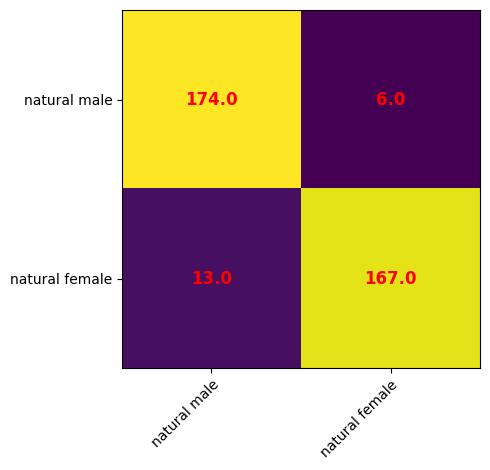

In [21]:
plot_confusion_matrix(conf_mat, ["natural male", "natural female"])